In [24]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D
# from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
from sklearn import metrics
import h5py
from sklearn import utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential, load_model

In [4]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')
right_labels = [[1,0] for i in np.arange(0,len(right_images))]
left_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')
left_labels = [[0,1] for i in np.arange(0,len(left_images))]

In [5]:
#adding left images to create "assumed right images"
for img in left_images:
    np.append(right_images,img)
    np.append(right_labels,[1,0])

In [6]:
new_left_images = []
new_left_labels = []
for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append([0,1])

In [7]:
right_images.shape

(383, 128, 128)

In [8]:
X_train = np.concatenate((right_images[:191],new_left_images[:191]),axis =0)
Y_train = np.concatenate((right_labels[:191],new_left_labels[:191]),axis = 0)
X_test = np.concatenate((right_images[191:286],new_left_images[191:286]),axis = 0)
Y_test = np.concatenate((right_labels[191:286],new_left_labels[191:286]),axis = 0)

In [6]:
X_train_norm = X_train/X_train.max()
X_test_norm = X_test/X_test.max()
X_train_norm = np.expand_dims(X_train_norm,axis=3)
X_test_norm = np.expand_dims(X_test_norm,axis=3)

In [7]:
X_train_shuff, Y_train_shuff = utils.shuffle(X_train_norm, Y_train,random_state=0)
X_test_shuff, Y_test_shuff = utils.shuffle(X_test_norm, Y_test,random_state=0)

In [8]:
i = h5py.File('20200514_Train_shuff_Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.h5','w')
i.create_dataset('images',data=X_train_shuff)
i.create_dataset('labels',data=Y_train_shuff)
i.close()

In [9]:
i = h5py.File('20200514_Test_shuff_Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.h5','w')
i.create_dataset('images',data=X_test_shuff)
i.create_dataset('labels',data=Y_test_shuff)
i.close()

In [10]:
batch_size = 20
seed = 42
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow(X_train_shuff, y=Y_train_shuff, batch_size=batch_size,seed=seed)
val_generator = test_datagen.flow(X_test_shuff,y=Y_test_shuff,batch_size=batch_size,seed=seed)

In [25]:
modelB = Sequential()
modelB.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(32, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(64, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(64, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Conv2D(64, (3, 3)))
modelB.add(Activation('relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelB.add(Dense(64))
modelB.add(Activation('relu'))
modelB.add(Dropout(0.5))
modelB.add(Dense(2))
modelB.add(Activation('softmax'))

modelB.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [26]:
historyB = modelB.fit_generator(
        train_generator,
        steps_per_epoch=500 // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=200 // batch_size)

Epoch 1/20
25/25 [==============================] - 6s 256ms/step - loss: 0.6955 - acc: 0.4867 - val_loss: 0.6970 - val_acc: 0.5000
Epoch 2/20
25/25 [==============================] - 6s 227ms/step - loss: 0.6987 - acc: 0.4965 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/20
25/25 [==============================] - 6s 230ms/step - loss: 0.6941 - acc: 0.5173 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 4/20
25/25 [==============================] - 6s 236ms/step - loss: 0.6951 - acc: 0.4887 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/20
25/25 [==============================] - 6s 226ms/step - loss: 0.6972 - acc: 0.5193 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 6/20
25/25 [==============================] - 6s 228ms/step - loss: 0.6924 - acc: 0.5060 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 7/20
25/25 [==============================] - 6s 237ms/step - loss: 0.6940 - acc: 0.5100 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 8/20
25/25 [==============================] - 6s 226ms/step - loss: 0.

In [34]:
# didn't train even though last time this model worked 
#adding rotation back in train generator
batch_size = 20
seed = 42
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow(X_train_shuff, y=Y_train_shuff, batch_size=batch_size,seed=seed)
val_generator = test_datagen.flow(X_test_shuff,y=Y_test_shuff,batch_size=batch_size,seed=seed)

In [28]:
modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelC.add(Activation('relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Conv2D(32, (3, 3)))
modelC.add(Activation('relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Conv2D(64, (3, 3)))
modelC.add(Activation('relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Conv2D(64, (3, 3)))
modelC.add(Activation('relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Conv2D(64, (3, 3)))
modelC.add(Activation('relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelC.add(Dense(64))
modelC.add(Activation('relu'))
modelC.add(Dropout(0.5))
modelC.add(Dense(2))
modelC.add(Activation('softmax'))

modelC.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
historyC = modelC.fit_generator(
        train_generator,
        steps_per_epoch=500 // batch_size,
        epochs=40,
        validation_data=val_generator,
        validation_steps=200 // batch_size)

Epoch 1/40
25/25 [==============================] - 6s 247ms/step - loss: 0.7010 - acc: 0.4867 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 2/40
25/25 [==============================] - 6s 235ms/step - loss: 0.6951 - acc: 0.5140 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/40
25/25 [==============================] - 8s 302ms/step - loss: 0.6935 - acc: 0.4927 - val_loss: 0.7076 - val_acc: 0.5000
Epoch 4/40
25/25 [==============================] - 7s 281ms/step - loss: 0.6965 - acc: 0.5080 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 5/40
25/25 [==============================] - 6s 251ms/step - loss: 0.6954 - acc: 0.4772 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/40
25/25 [==============================] - 6s 245ms/step - loss: 0.6990 - acc: 0.4987 - val_loss: 0.6928 - val_acc: 0.5368
Epoch 7/40
25/25 [==============================] - 6s 258ms/step - loss: 0.6940 - acc: 0.4707 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 8/40
25/25 [==============================] - 6s 256ms/step - loss: 0.

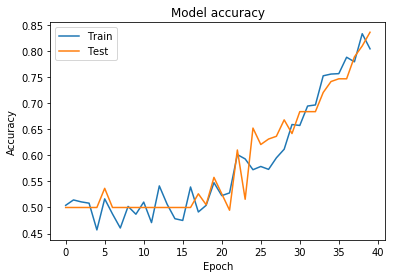

In [30]:
plt.plot(historyC.history['acc'])
plt.plot(historyC.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

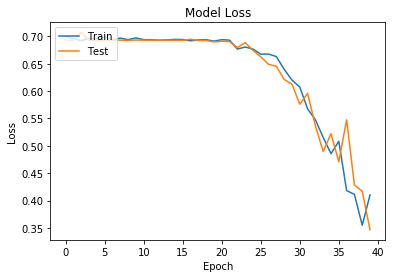

In [37]:
plt.plot(historyC.history['loss'])
plt.plot(historyC.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
#Seems to take many epochs for learning to start
#retrying with no rotation but more epcohs

In [35]:
modelD = Sequential()
modelD.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Conv2D(32, (3, 3)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Conv2D(64, (3, 3)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Conv2D(64, (3, 3)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Conv2D(64, (3, 3)))
modelD.add(Activation('relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelD.add(Dense(64))
modelD.add(Activation('relu'))
modelD.add(Dropout(0.5))
modelD.add(Dense(2))
modelD.add(Activation('softmax'))

modelD.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [36]:
historyD = modelD.fit_generator(
        train_generator,
        steps_per_epoch=500 // batch_size,
        epochs=60,
        validation_data=val_generator,
        validation_steps=200 // batch_size)

Epoch 1/60
25/25 [==============================] - 6s 255ms/step - loss: 0.7088 - acc: 0.4960 - val_loss: 0.6941 - val_acc: 0.5000
Epoch 2/60
25/25 [==============================] - 6s 232ms/step - loss: 0.6915 - acc: 0.5221 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 3/60
25/25 [==============================] - 6s 238ms/step - loss: 0.6962 - acc: 0.4747 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/60
25/25 [==============================] - 6s 249ms/step - loss: 0.6948 - acc: 0.4840 - val_loss: 0.6929 - val_acc: 0.5526
Epoch 5/60
25/25 [==============================] - 6s 243ms/step - loss: 0.6947 - acc: 0.4680 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/60
25/25 [==============================] - 7s 261ms/step - loss: 0.6931 - acc: 0.5133 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 7/60
25/25 [==============================] - 6s 253ms/step - loss: 0.6968 - acc: 0.4739 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 8/60
25/25 [==============================] - 6s 257ms/step - loss: 0.

# Adding Garbage to Make Weaker Labels

In [9]:
garbage_imgs = np.load('20200514_garbage__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')

In [10]:
garbage_imgs.shape

(160, 128, 128)

In [11]:
X_train.shape[0]*0.2*0.5

38.2

In [12]:
X_test.shape[0]*0.2*0.5

19.0

In [13]:
garbage_right_train = garbage_imgs[:38]
garbage_right_labels_train = [[1,0] for i in np.arange(0,len(garbage_right_train))]
garbage_left_train = []
for img in garbage_right_train:
    garbage_left_train.append(np.fliplr(img))
garbage_left_labels_train = [[0,1] for i in np.arange(0,len(garbage_left_train))]

In [14]:
garbage_right_test = garbage_imgs[38:38+19]
garbage_right_labels_test = [[1,0] for i in np.arange(0,len(garbage_right_test))]
garbage_left_test = []
for img in garbage_right_test:
    garbage_left_test.append(np.fliplr(img))
garbage_left_labels_test = [[0,1] for i in np.arange(0,len(garbage_left_test))]

In [15]:
X_train = np.concatenate((X_train,garbage_left_train,garbage_right_train),axis =0)
Y_train = np.concatenate((Y_train,garbage_left_labels_train,garbage_right_labels_train),axis = 0)
X_test = np.concatenate((X_test,garbage_left_test,garbage_right_test),axis = 0)
Y_test = np.concatenate((Y_test,garbage_left_labels_test,garbage_right_labels_test),axis = 0)

In [16]:
X_train_norm = X_train/X_train.max()
X_test_norm = X_test/X_test.max()
X_train_norm = np.expand_dims(X_train_norm,axis=3)
X_test_norm = np.expand_dims(X_test_norm,axis=3)

In [17]:
X_train_shuff, Y_train_shuff = utils.shuffle(X_train_norm, Y_train,random_state=0)
X_test_shuff, Y_test_shuff = utils.shuffle(X_test_norm, Y_test,random_state=0)

In [18]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
batch_size = 20
seed = 42
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow(X_train_shuff, y=Y_train_shuff, batch_size=batch_size,seed=seed)
val_generator = test_datagen.flow(X_test_shuff,y=Y_test_shuff,batch_size=batch_size,seed=seed)

In [21]:
historyE = modelE.fit_generator(
        train_generator,
        steps_per_epoch=500 // batch_size,
        epochs=60,
        validation_data=val_generator,
        validation_steps=200 // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
25/25 [==============================] - 4s 150ms/step - loss: 0.6972 - accuracy: 0.4920 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 2/60
25/25 [==============================] - 4s 143ms/step - loss: 0.6954 - accuracy: 0.5080 - val_loss: 0.6940 - val_accuracy: 0.4734
Epoch 3/60
25/25 [==============================] - 4s 144ms/step - loss: 0.6960 - accuracy: 0.5120 - val_loss: 0.6930 - val_accuracy: 0.5053
Epoch 4/60
25/25 [==============================] - 4s 141ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.7053 - val_accuracy: 0.4574
Epoch 5/60
25/25 [==============================] - 4s 146ms/step - loss: 0.6962 - accuracy: 0.4839 - val_loss: 0.6942 - val_accuracy: 0.4574
Epoch 6/60
25/25 [==============================] - 4s 141ms/step - loss: 0.6935 - accuracy: 0.5060 - val_loss: 0.6910 - val_accuracy: 0.5426
Epoch 7/60
25/25 [==============================] - 4s 144ms/step - loss

25/25 [==============================] - 4s 143ms/step - loss: 0.1062 - accuracy: 0.9518 - val_loss: 0.4058 - val_accuracy: 0.8670
Epoch 57/60
25/25 [==============================] - 4s 141ms/step - loss: 0.0864 - accuracy: 0.9659 - val_loss: 0.4758 - val_accuracy: 0.8511
Epoch 58/60
25/25 [==============================] - 4s 157ms/step - loss: 0.1045 - accuracy: 0.9637 - val_loss: 0.4226 - val_accuracy: 0.8989
Epoch 59/60
25/25 [==============================] - 4s 141ms/step - loss: 0.0629 - accuracy: 0.9759 - val_loss: 0.5442 - val_accuracy: 0.8936
Epoch 60/60
25/25 [==============================] - 4s 145ms/step - loss: 0.0793 - accuracy: 0.9759 - val_loss: 0.4113 - val_accuracy: 0.8750


In [17]:
tf.__version__

'2.2.0'

In [18]:
keras.__version__

'2.3.0-tf'

In [22]:
modelE.save_weights('chirality_classification_20pwronglabels_weights_20200712.h5')

In [ ]:
historyE.history[]

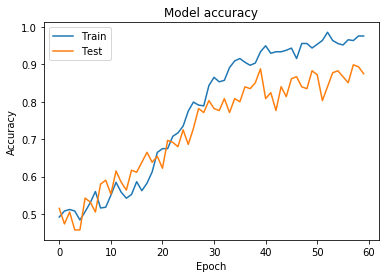

In [26]:
plt.plot(historyE.history['accuracy'])
plt.plot(historyE.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

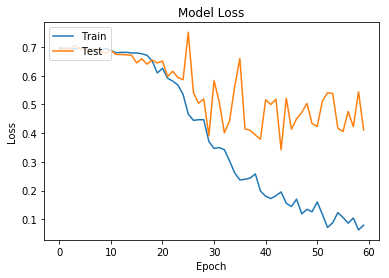

In [28]:
plt.plot(historyE.history['loss'])
plt.plot(historyE.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()